In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

In [2]:
data = pd.read_pickle('df_tesco_marker_V3.pkl')

In [3]:
data.shape

(61990, 56)

In [4]:
data.columns

Index(['Site Number', 'Site Name', 'Transaction Date', 'Total Sales Value',
       'Total Baskets', 'Sales Baskets With Fuel', 'Baskets With Fuel',
       'Site ID', 'PBL', 'CRUSO_priceADO', 'CRUSO_priceUL95', 'volumeADO',
       'volumeUL95', 'sales_valADO', 'sales_valUL95', 'totalSalesEsso',
       'pct_dev', 'diff_shop_esso', 'SiteCode', 'SiteName', 'Date',
       'UL 95_ Sales Transaction Volume', 'UL 95_ Approved Price',
       'UL 95_ Marker Price', 'UL 95_ Approved Price Vs Marker Price',
       'ADO_ Sales Transaction Volume', 'ADO_ Approved Price',
       'ADO_ Marker Price', 'ADO_ Approved Price Vs Marker Price',
       'avgUL95VolSite', 'avgADOVolSite', 'diffAdoVol', 'diffUL95Vol',
       'diffAdoVolpct', 'diffUL95Volpct', 'diffAdoPricePct',
       'diffUL95PricePct', 'avgShopSalesFromFuelSiteWise',
       'pctChgShopSalesFromFuel', 'shopSales', 'avgShopSalesSiteWise',
       'ShopSalesPctChgFromAvg', 'AdoApprPriceChgPct', 'UL95AppPriceChgPct',
       'avgFuelSalesEssoSiteWi

In [5]:
# calcualting exclusive shop sales and shop slaes from fuel for sites:
data['exclShopSales'] = data['Total Sales Value']-data['Sales Baskets With Fuel']
data['shopSalesFromFuel'] = data['Sales Baskets With Fuel']-data['totalSalesEsso']

In [6]:
# selecting only required data for elasticity calculation:
seldf = data.loc[:,['Site Number', 'shopSalesFromFuel', 'UL 95_ Approved Price','UL 95_ Marker Price']]

In [7]:
seldf.drop(list(seldf[seldf['shopSalesFromFuel'] == 0].index), axis=0, inplace=True)

In [8]:
seldf.describe()

Site Number  shopSalesFromFuel  UL 95_ Approved Price  \
count  61990.000000       61990.000000           61990.000000   
mean    3745.035441        2201.566828             125.976399   
std     1358.669466         827.340172               3.127660   
min     2001.000000       -2358.313230             114.900000   
25%     2553.000000        1622.594022             123.900000   
50%     3156.000000        2099.136680             125.900000   
75%     5288.000000        2686.052192             127.900000   
max     6119.000000       13649.831100             136.900000   

       UL 95_ Marker Price  
count         61990.000000  
mean            125.271806  
std               3.154805  
min             113.700000  
25%             123.700000  
50%             125.700000  
75%             127.300000  
max             136.900000

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def get_plot(df):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'])
    line = slope*X+intercept

    df['Fitted log(S0)'] = np.concatenate(line)

    fig = go.Figure(data=[
        go.Scatter(x= df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'],mode='markers', name='Actual', marker_color = 'gray'),
        go.Line(x= df['Actual log(P0/Pbar)'], y=df['Fitted log(S0)'], name='Fit', marker_color = 'firebrick')    
    ])

    fig.update_layout(
        #title = selectedCountry+' - Road Fuel Demand',
        yaxis_title="log(S0)",
        xaxis_title="log(P0/Pbar)",
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    #fig.show()
    #fig.write_image("fig1.pdf")
    return fig

In [11]:
elasticity = []
logSbar    = []
corrCoef   = []
pVal       = []
rmse       = []
r2         = []
mape       = []

for i in range(len(seldf['Site Number'].unique())): #for all sites 
    df = seldf[seldf['Site Number'] == seldf['Site Number'].unique()[i]]
    df.drop('Site Number', axis=1, inplace=True)
    df.columns = ['shopSales', 'P0', 'Pbar']
    data_df = pd.DataFrame()
    y = np.log(df['shopSales'].dropna().values).reshape(-1,1)
    pdiv = df['P0']/df['Pbar']
    X = np.log(pdiv.dropna()).values.reshape(-1,1)
    data_df = pd.concat([data_df, pd.DataFrame({'Actual log(S0)': y.flatten(), 'Actual log(P0/Pbar)': X.flatten()})], axis=0)
    data_df.drop(list(data_df[data_df.isnull().any(axis=1)].index), axis=0, inplace=True)
    #get_plot(data_df)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df['Actual log(P0/Pbar)'], y=data_df['Actual log(S0)'])
    elasticity.append(slope)
    logSbar.append(intercept)
    corrCoef.append(r_value)
    pVal.append(p_value)
    y_final = data_df['Actual log(S0)']
    X_final = data_df['Actual log(P0/Pbar)']
    rmse.append(round(np.sqrt(metrics.mean_squared_error(y_final, slope*X_final+intercept)),4))
    r2.append(round(metrics.r2_score(y_final, slope*X_final+intercept),4))
    mape.append(round(mean_absolute_percentage_error(y_final,slope*X_final+intercept),4))   

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFra

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:



/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:



/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:



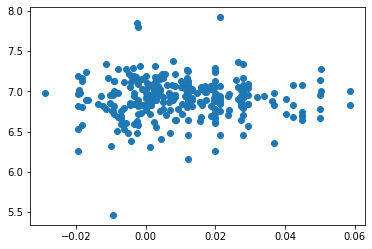

In [12]:
import matplotlib.pyplot as plt
plt.scatter(data_df['Actual log(P0/Pbar)'], data_df['Actual log(S0)'])

In [13]:
# df = data_df
# slope, intercept, r_value, p_value, std_err = stats.linregress(df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'])
# line = slope*X+intercept

# df['Fitted log(S0)'] = np.concatenate(line)

# fig = go.Figure(data=[
#     go.Scatter(x= df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'],mode='markers', name='Actual', marker_color = 'gray'),
#     go.Line(x= df['Actual log(P0/Pbar)'], y=df['Fitted log(S0)'], name='Fit', marker_color = 'firebrick')    
# ])

# fig.update_layout(
#     #title = selectedCountry+' - Road Fuel Demand',
#     yaxis_title="log(S0)",
#     xaxis_title="log(P0/Pbar)",
#     plot_bgcolor='rgba(0,0,0,0)'
# )

# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.show()

In [14]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(data_df['Actual log(P0/Pbar)'], y=data_df['Actual log(S0)'])
# elasticity.append(slope)
# logSbar.append(intercept)
# corrCoef.append(r_value)
# pVal.append(p_value)
# rmse.append(round(np.sqrt(metrics.mean_squared_error(y, slope*X+intercept)),4))
# r2.append(round(metrics.r2_score(y, slope*X+intercept),4))
# mape.append(round(mean_absolute_percentage_error(y,slope*X+intercept),4))   

In [15]:
result_df = pd.DataFrame({'elasticity': elasticity, 'constant': logSbar, 'p-value':pVal, 'r2':r2, 'mape': mape, 'rmse':rmse})

In [16]:
result_df

elasticity  constant   p-value      r2    mape    rmse
0     -0.907706  6.865662  0.624932  0.0007  2.6138  0.2728
1      1.696703  7.454428  0.254410  0.0040  2.0352  0.1944
2      0.712079  7.914157  0.671384  0.0006  1.5746  0.1648
3      4.615568  7.570843  0.111862  0.0080  3.0004  0.3844
4     -4.319773  7.565499  0.032249  0.0151  2.9118  0.3019
..          ...       ...       ...     ...     ...     ...
191    1.584795  7.887421  0.214715  0.0048  1.7323  0.1885
192   -0.986371  7.976363  0.410752  0.0021  1.7631  0.1784
193    2.093333  7.649677  0.026561  0.0166  2.1598  0.2206
194    0.236569  7.525296  0.798746  0.0002  2.0278  0.2230
195   -0.058640  6.924787  0.946622  0.0000  2.5418  0.2436

[196 rows x 6 columns]

In [17]:
result_df[result_df['p-value'] < 0.05].shape

(59, 6)

In [18]:
import plotly.express as px
fig = px.histogram(result_df, x="elasticity", nbins=20)
fig.show()

In [19]:
result_df.to_csv("UL95_shopSalesFromFuel_elasticity")

In [20]:
result_df.describe()

elasticity    constant       p-value          r2        mape  \
count  196.000000  196.000000  1.960000e+02  196.000000  196.000000   
mean     0.172965    7.630721  3.150486e-01    0.012848    2.155005   
std      2.685888    0.321115  3.135858e-01    0.020943    0.753281   
min     -9.761064    6.696425  3.188524e-08    0.000000    0.990100   
25%     -1.124492    7.426627  2.575380e-02    0.001200    1.731950   
50%      0.202516    7.647379  2.098159e-01    0.004900    1.968050   
75%      1.575277    7.866204  5.281363e-01    0.017375    2.261975   
max     13.128816    8.399462  9.877244e-01    0.178200    6.289700   

             rmse  
count  196.000000  
mean     0.221908  
std      0.075030  
min      0.091800  
25%      0.176550  
50%      0.197300  
75%      0.242475  
max      0.603700